### Step 1: Import Data with CoinPaprika API (https://api.coinpaprika.com/)

In [2]:
import Coinpaprika
import pandas as pd                        
from pytrends.request import TrendReq

api_client = Coinpaprika.Client()
market_overview = api_client.global_market_overview()

#print(market_overview)

all_coins = api_client.coins()
for i  in range(0, 10):
    print(all_coins[i]['id'])

btc-bitcoin
eth-ethereum
bnb-binance-coin
xrp-xrp
usdt-tether
doge-dogecoin
ada-cardano
dot-polkadot
ltc-litecoin
bch-bitcoin-cash


## get historical data 

In [3]:
from datetime import datetime, timedelta

coin = 'btc-bitcoin'
color = 'green'

hist = api_client.coins.historical_OHLC(
    coin_id=coin,
    start=datetime.now() - timedelta(weeks=52) - timedelta(days=0),
    end=datetime.now() - timedelta(days=0)
)
# TODO: "clean up" data (na's, outliers, etc.)

In [4]:
def getNewsAverage(today):
    pytrends = TrendReq()

    kw_list = ["Bitcoin"]

    # get timeframe of last 28 days
    #today = hist[0]['time_open']
    new_date = today - timedelta(days=3)
    toString = today.strftime("%Y-%m-%d")
    fromString = new_date.strftime("%Y-%m-%d")
    timespan = fromString + " " + toString
    
    print(timespan)

    pytrends.build_payload(kw_list, cat=0, timeframe=timespan, geo='', gprop='')
    df = pytrends.interest_over_time()

    #return df;
    #return df['Bitcoin'][0];

    # calculate average
    average = 0
    for i in range(0, len(df['Bitcoin'])):
        average += df['Bitcoin'][i]
    average /= len(df['Bitcoin'])
    return average
    

In [5]:
#for i in range(0,len(hist)):
#    print("---")
#    print(i)
#    print(hist[i]['time_open'])
#    print(getNewsAverage(hist[i]['time_open']))

In [67]:
#alldata = []
#for i in range(0,len(hist)):
#    # 0: pdctPositive, 1: PDCT predicted difference closing tomorrow, 2: closing, 3: variance, 4: time_open, 5: volume, 6: open, 7: low, 8: high
#    variance = hist[i]['high'] - hist[i]['low']
#    if(i == 0):
#        pdct = 0
#    else:
#        pdct = hist[i]['close'] - hist[i-1]['close']
        
#    pdctPositive = pdct > 0
    #alldata.append({
    #    "pdctPositive": pdctPositive, 
    #    "pdct": pdct, 
    #    "close": hist[i]['close'], 
    #    "variance": variance, 
    #    "time_open": hist[i]['time_open'], 
    #    "volume": hist[i]['volume'], 
    #    "open": hist[i]['open'], 
    #    "low": hist[i]['low'], 
    #    "high": hist[i]['high']})
alldata = []
for i in range(0,len(hist)):
    if(i==0):
        alldata.append({
            "close": hist[0]['close'],
            "low": hist[0]['low'],
            "high": hist[0]['high'],
            "volume": hist[0]['volume']
        })
    else:
        alldata.append({
            "close": hist[i]['close'],
            "low": hist[i-1]['low'],
            "high": hist[i-1]['high'],
            "volume": hist[i-1]['volume']
        })

In [68]:
#hist[0]
#for i in range(0, len(alldata)):
#    print(alldata[i]['news'])

In [69]:
import matplotlib.pyplot as plt

graphdata = []
for i in range(0, len(alldata)):
    graphdata.append(alldata[i]['variance'])
pdct = []
for i in range(0, len(alldata)):
    pdct.append(alldata[i]['pdct'])

plt.plot(graphdata, "green")
plt.plot(pdct, "red")
plt.xlabel("Tage")
plt.grid(True)
plt.show()

KeyError: 'variance'

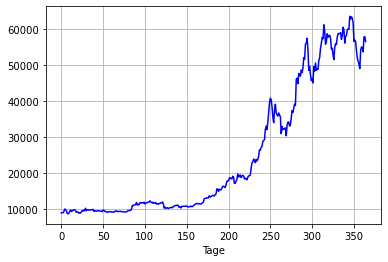

In [70]:
close = []
for i in range(0, len(alldata)):
    close.append(alldata[i]['close'])

plt.plot(close, "blue")
plt.grid(True)
plt.xlabel("Tage")
plt.show()

## Ziel: LinearRegression

315
0.28376789945540926


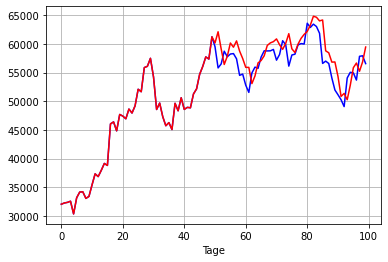

In [93]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor

# testdate: all except last week
numberOfTestData = 50

alldata = pd.DataFrame(alldata)

feature_cols = ['volume', 'low', 'high']
#feature_cols = ['pdctPositive', 'pdct', 'variance', 'volume', 'open', 'low', 'high']

X = alldata[feature_cols]       # Features
y = alldata['close']            # Target variable

X_train = X[:-numberOfTestData]
X_test  = X[-numberOfTestData:]
y_train = y[:-numberOfTestData]
y_test  = y[-numberOfTestData:]

print(len(X_train))

# Create
lr = LinearRegression();

# Train
lr = lr.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = lr.predict(X_test)

reg_metrics(y_test, y_pred, X_train)

# tail the prediction
predline = []
u = 0
for i in range(0, len(alldata)):
    if(i < len(alldata) - numberOfTestData):
        predline.append(close[i])
    else:
        predline.append(y_pred[u])
        u+=1

plotlineClose = []
plotlinePred = []
for i in range(len(alldata)-(2*numberOfTestData), len(alldata)):
    plotlineClose.append(close[i])
    plotlinePred.append(predline[i])


        
        
        
plt.plot(plotlineClose, "blue")
plt.plot(plotlinePred, "red")
plt.grid(True)
plt.xlabel("Tage")
plt.show()

In [14]:
def reg_metrics(y_test, y_pred, X_train):
    from sklearn.metrics import mean_squared_error, r2_score 

    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    # Scikit-learn doesn't have adjusted r-square, hence custom code
    n = y_pred.shape[0]
    k = X_train.shape[1]
    adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)

    print(adj_r_sq)